# Lab 1 - Creating a CNN Classifier

In this lab, you will use PyTorch to create a convolutional neural network to classify the vehicle images you prepared in the previous lab.

> **Important**: If you did not complete Lab 1, use the sample solution notebook for that lab to prepare the training images you will need in this lab!

## Set up a Deep Learning Framework

Install PyTorch and import libraries.

> *Note: The following `pip install` commands install the CPU-based version of PyTorch on Linux, which is appropriate for the Azure Notebooks environment. For instructions on how to install the PyTorch and TorchVision packages on your own system, see https://pytorch.org/get-started/locally/*

In [1]:
# Install PyTorch
#!pip install https://download.pytorch.org/whl/cpu/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl
#!pip install torchvision

# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.3.1


## Prepare the Data

In the following cell, write code to load the training data and split it into a training set and a validation set.

> - Use **ImageDataGenerator** objects to load the data
> - Normalize the pixel values in the range 0-255 as you load them.
> - Split the data into 70% for training, 30% for validation.
> - Create a list of class names that corresponds to the class labels in your dataset.

In [2]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=images_per_batch,
        num_workers=1,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=images_per_batch,
        num_workers=1,
        shuffle=False
    )
        
    return train_loader, test_loader

import os

train_folder = "../data/classification/training"
img_size = (128,128)
images_per_batch = 18

# Get the class names
classes = os.listdir(train_folder)
classes.sort()
print(classes)

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(train_folder)

['automobile', 'plane', 'train']


## Define the CNN
Define the layers in your CNN:

> - Use *convolution* layers to extract feature based on filter kernels.
> - Use pooling layers to downsample the extracted features.
> - To improve your model, experiment with adding layers (making the network deeper) and adding filters (making the network broader).

In [3]:
# Create a neural net class
class Net(nn.Module):
    # Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        # Our images are RGB, so input channels = 3. We'll apply 24 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 24 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 24 input channels, and generates 48 outputs
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride=1, padding=1)
        
        # We'll apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # Our 128x128 image tensors will be pooled three times with a kernel size of 2. 128/2/2/2 is 16.
        # So our feature tensors are now 32 x 32, and we've generated 48 of them so our array is 16x16x48
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to  the probability for each class
        self.fc = nn.Linear(in_features=16 * 16 * 48, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after convolution 1 and pool
        x = F.relu(self.pool(self.conv1(x)))
      
        # Use a relu activation function after convolution 2 and pool
        x = F.relu(self.pool(self.conv2(x)))
        
        # Use a relu activation function after convolution 2)
        x = F.relu(self.conv2(x))
        
        # Use a relu activation function after convolution 2
        x = F.relu(self.conv2(x))
        
         # Use a relu activation function after convolution 3 and pool
        x = F.relu(self.pool(self.conv3(x)))
        
        # Flatten
        x = x.view(-1, 16 * 16 * 48)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return F.log_softmax(x, dim=1)
    
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

print(model)

Net(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=12288, out_features=3, bias=True)
)


## Train the Model

Train the model using the training dataset, and validating after each epoch with the validation dataset.

> - Choose an appropriate optimizer and learning rate - Refer to the framework documentation as you experiment with this.
> - Run the training process over a reasonable number of epochs - start with 15 and increase / decrease based on your observations of validation loss.
> - Track both training and validation loss so you can observe training progress and plot the loss history after training.

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 25 epochs
epochs = 25
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
	Training batch 1 Loss: 1.096481
	Training batch 2 Loss: 1.287957
	Training batch 3 Loss: 1.082407
	Training batch 4 Loss: 1.104173
	Training batch 5 Loss: 1.239271
	Training batch 6 Loss: 1.174588
	Training batch 7 Loss: 1.068058
	Training batch 8 Loss: 1.073336
	Training batch 9 Loss: 1.071682
	Training batch 10 Loss: 1.200626
Training set: Average loss: 1.139858
Validation set: Average loss: 1.148545, Accuracy: 15/72 (21%)

Epoch: 2
	Training batch 1 Loss: 1.108406
	Training batch 2 Loss: 1.090514
	Training batch 3 Loss: 1.147575
	Training batch 4 Loss: 1.093760
	Training batch 5 Loss: 0.995638
	Training batch 6 Loss: 1.121677
	Training batch 7 Loss: 1.085156
	Training batch 8 Loss: 1.007166
	Training batch 9 Loss: 1.054304
	Training batch 10 Loss: 1.070702
Training set: Average loss: 1.077490
Validation set: Average loss: 1.109058, Accuracy: 15/72 (21%)

Epoch: 3
	Training batch 1 Loss: 1.027904
	Training batch 2 Loss: 1.134766
	Training batch 3 Loss: 1.119

	Training batch 9 Loss: 0.063757
	Training batch 10 Loss: 0.009689
Training set: Average loss: 0.080171
Validation set: Average loss: 1.006931, Accuracy: 52/72 (72%)

Epoch: 20
	Training batch 1 Loss: 0.015748
	Training batch 2 Loss: 0.296531
	Training batch 3 Loss: 0.031908
	Training batch 4 Loss: 0.026199
	Training batch 5 Loss: 0.053184
	Training batch 6 Loss: 0.152944
	Training batch 7 Loss: 0.012008
	Training batch 8 Loss: 0.072585
	Training batch 9 Loss: 0.056764
	Training batch 10 Loss: 0.108061
Training set: Average loss: 0.082593
Validation set: Average loss: 0.838317, Accuracy: 55/72 (76%)

Epoch: 21
	Training batch 1 Loss: 0.121838
	Training batch 2 Loss: 0.023528
	Training batch 3 Loss: 0.056825
	Training batch 4 Loss: 0.091566
	Training batch 5 Loss: 0.126633
	Training batch 6 Loss: 0.208221
	Training batch 7 Loss: 0.036032
	Training batch 8 Loss: 0.073455
	Training batch 9 Loss: 0.079532
	Training batch 10 Loss: 0.004605
Training set: Average loss: 0.082223
Validation set

## View Loss History

Use matplotlib to plot the training and validation loss history.

> - Experiment with adding model layers and filters, changing activation functions,, or using a different optimizer or learning rate to achieve a lower loss - you should restart the kernel between each attempt!
> - If the training loss continues to drop, but the validation loss doesn't - the model is *overfitting*. We'll explore options to address this later in the course.

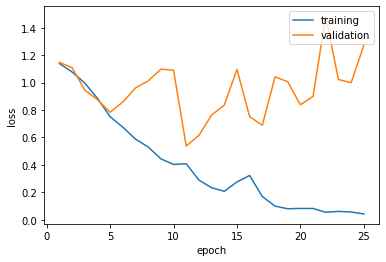

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline


plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## View Model Performance

Plot a confusion matrix to observe how the model performs:

> - Use some or all of the validation data to generate metrics for the confusion matrix.
> - Use the **sklearn.metrics.confusion_matrix** object to create the confusion matrix.

Getting predictions from test set...


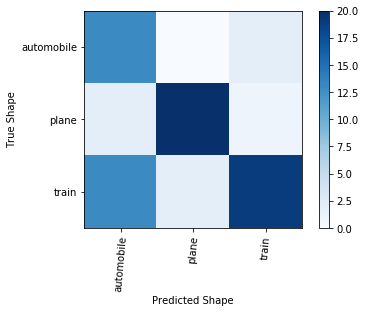

In [6]:
#Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import numpy as np

truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in model(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=85)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("True Shape")
plt.show()

## Save the Model Weights

After you've trained the model, save the model weights so you can reuse it later.

> - Save the weights, not the entire model.
> - See [PyTorch documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for information about saving PyTorch weights. 

In [7]:
# Save the model weights
model_file = 'vehicle-classifier.pt'
torch.save(model.state_dict(), model_file)
print("Model saved.")

# Delete the existing model variable
del model

Model saved.


## Use the Model to Classify New Images

Now you can use your model to infer the class of new images.

- Use the images in the **../data/classification/test** folder to test your model.
- Remember to prepare your new imagfes the same way you prepared the training images - they must be the same size and have the same transformations applied to them.
- Consider creating functions to encapsulate image preparation class prediction.

In [8]:
# Helper function to resize image
def resize_image(src_img, size=(128,128), bg_color="white"): 
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
  
    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
   
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # These are the classes our model can predict
    class_names = ['automobile', 'plane', 'train']
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the imagees
    image_tensor = torch.stack([transformation(image).float() for image in image_array])

    # Turn the input into a Variable
    input_features = image_tensor

    # Predict the class of each input image
    predictions = classifier(input_features)
    
    predicted_classes = []
    # Convert the predictions to a numpy array 
    for prediction in predictions.data.numpy():
        # The prediction for each image is the probability for each class, e.g. [0.8, 0.1, 0.2]
        # So get the index of the highest probability
        class_idx = np.argmax(prediction)
        # And append the corresponding class name to the results
        predicted_classes.append(class_names[class_idx])
    return np.array(predicted_classes)

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


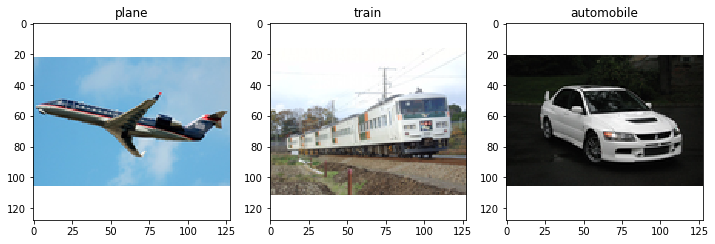

In [9]:
import os
from random import randint
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

# load the saved model weights
model = Net(num_classes=3)
model.load_state_dict(torch.load(model_file))


#get the list of test image files
test_folder = '../data/classification/test'
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (128,128)
background_color = "white"

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))
    
    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))
                      
    # Add the image to the array of images
    image_arrays.append(resized_img)

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(model, np.array(image_arrays))

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(1,len(predictions),idx+1)
    imgplot = plt.imshow(image_arrays[idx])
    a.set_title(predictions[idx])
